In [1]:
import gzip
from tensorflow.keras.utils import to_categorical

In [2]:
# Useful additional packages
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from math import pi

In [213]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity
from qiskit import  Aer, transpile, IBMQ, assemble
from qiskit.circuit.library import CHGate
from qiskit.quantum_info.operators import Operator
from qiskit.aqua.operators import PrimitiveOp, CircuitStateFn
from qiskit.aqua.operators.primitive_ops import MatrixOp
from qiskit.aqua.operators.converters import CircuitSampler
from qiskit.aqua.operators.expectations import ExpectationFactory
from qiskit.aqua.operators.list_ops import ComposedOp
from qiskit.aqua.operators import ListOp
from qiskit.aqua.operators import Zero

In [4]:
provider = IBMQ.load_account()

In [214]:
print(Aer.backends())
simulator = Aer.get_backend("statevector_simulator")
# simulator.set_option(method=)
my_sampler = CircuitSampler(backend=simulator, attach_results=True, param_qobj=False)  # read up on this more
my_expectation = ExpectationFactory()

[QasmSimulator(
backend_name='qasm_simulator', provider=AerProvider()), StatevectorSimulator(
backend_name='statevector_simulator', provider=AerProvider()), UnitarySimulator(
backend_name='unitary_simulator', provider=AerProvider()), PulseSimulator(
backend_name='pulse_simulator', provider=AerProvider())]


In [6]:
# EMNIST decoder

decoder = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

In [8]:
images_raw = gzip.open("data/EMNIST/gzip/emnist-balanced-train-images-idx3-ubyte.gz", "r")
labels_raw = gzip.open("data/EMNIST/gzip/emnist-balanced-train-labels-idx1-ubyte.gz")


image_size = 28
num_images = 512 # how many images per batch

images_raw.read(16) # reads the data type
labels_raw.read(8) # reads the data type

def get_data(images, labels):
    buf_images = images.read(image_size * image_size * num_images)
    images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32)
    images = images.reshape(num_images, image_size, image_size, 1)
    
    buf_labels = labels.read(num_images)
    labels = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int32)
    
    return images, labels

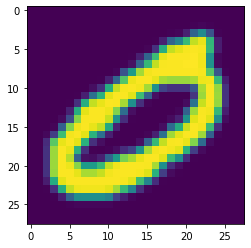

0


In [9]:
# print images
data = get_data(images_raw, labels_raw)

images = data[0]
labels = data[1]



sort_index = np.argsort(data[1], axis=0)

sorted_images = data[0][sort_index]
sorted_labels = data[1][sort_index]

sorted_data = sorted_images, sorted_labels

image = np.asarray(sorted_images[1]).T.squeeze()
plt.imshow(image)
plt.show()

print(decoder[sorted_labels[1]])

In [10]:
print(sorted_labels)

[ 0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  2  2  2  2  2
  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  6  6
  6  6  6  6  6  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8
  8  8  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10
 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11 11 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 14 14 14 14 14
 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 15 15 15 16 16 16 16 16
 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18
 18 18 18 18 18 18 19 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 21 21 21 21 21 21 21 21 22 22 22 22 22 22 22 23
 23 23 23 23 23 23 23 23 24 24 24 24 24 24 24 24 25 25 25 25 25 25 25 25
 25 25 25 25 25 25 25 26 26 26 26 26 26 26 27 27 27 27 27 27 27 27 27 27
 28 28 28 28 28 28 28 28 28 29 29 29 29 29 29 29 29

In [11]:
def get_num_cls(data):
    labels = np.array(data[1])
    one_hot_labels = to_categorical(labels)
    
    return one_hot_labels.shape[1]


In [12]:
N = get_num_cls(data)
print(N)

47


In [395]:
class Forward_and_backward:
    """see:
        https://arxiv.org/pdf/1908.08385.pdf
        equations 1 and 2
        also see:
        https://qiskit.org/documentation/stubs/qiskit.circuit.library.CHGate.html
    """
    def __init__(self, N, data, num_of_it):
        """"""
        self.num_of_it = num_of_it
        self.N = 1
        self.target_N = N
        self.SU_of_N = np.asarray([[1]])
        self.data = data
        self.alpha = np.arange(start=1, stop= self.target_N ** 2 + 1, dtype=np.complex_)
        self.K = 1
        self.P = self.K * np.exp(1j * np.asarray([[0, -1j], [1j, 0]])) * self.K


    
    def H(self):
        """"""
        h = []
        
        for i in range(self.target_N):
            h.append([0])

        #print(h)
        
        for i in range(self.target_N):
            for k in range(self.target_N):
                term0 = np.exp(((1j * 2 * np.pi * i * k)  / self.target_N))
                try:
                    term1 = term1 + term0
                except:
                    term1 = term0

            h[i] = term1
        h = np.asarray(h, dtype=object)
        H_op = 1 / np.sqrt(self.target_N) * h

        return H_op
        
    def quNit(self):
        S3 = np.zeros(shape=(self.target_N, self.target_N))
        np.fill_diagonal(S3, val=-(self.target_N - 1) / 2)
        # print(self.x.shape)
        W = np.zeros(shape=self.x.shape) # learnable similar to weights
        # print(W.shape)
        sum_of_weights = np.sum(np.vdot(W[:], self.x[:]), ) # all x's of type i
        # print(sum_of_weights)
        Z = np.exp(1j * S3 * sum_of_weights)
        
        # Z_op = PrimitiveOp(Z)
        
        return Z * self.H() * Zero
 ##################################################   
    
    def driver_for_SUG(self):
        """finds the value for alpha which is a self.target_N set"""
        
        
        # print(self.SU_of_N.shape[0] * self.SU_of_N.shape[1])
        # print(self.alpha.shape)
        
        return self.SU_of_N / self.alpha.reshape(self.target_N, self.target_N)
    
    
    def direct_sum(self, a, b):
        """"""
        if isinstance(a, int) and a == 1:
            a = np.asarray([a])[np.newaxis]

        # print("a = ", a)
        # print("b = ", b)
        # dsum = np.zeros( np.add(a.shape,b.shape), dtype=np.complex_ )
        # dsum[:a.shape[0],:a.shape[1]]=a
        # dsum[a.shape[0]:,a.shape[1]:]=b
        dsum = a + b
        # print(dsum)
        return dsum

    def A(self, k, lie_alge, a):
        term0 = 1j * lie_alge * 3 * a * (2 * k - 3)
        term1 = np.exp(term0)
        term2 = 1j * lie_alge
        term3 = np.exp(term2)
        term4 = ((k-1) ** 2 + 1) * a * (2 * (k - 1))
        term5 = term3 * term4
        term6 = term1 * term5
        
        return term6

    def lie_algebra(self):
        
        if self.N == 1:
            return 1
        
        lie_alg = self.direct_sum(self.K,  self.P)
        
        # print("lie", lie_alg.shape)
        
        return lie_alg
    
    def mat(self):
        if self.N > 1:
            n = self.N
            mat = np.zeros(shape=(n, n), dtype=np.complex_)
            mat[0, n - 1] = -1j
            mat[n - 1, 0] = 1j
            
        else:
            mat = np.asarray([[1]], dtype=np.complex_)
        # print("mat", mat.shape)
        # print(mat)
        
        return mat
        
    
    def Euler_angle_param(self):
        """"""
        print("SU(N), N = ", self.N - 1)
        if self.N == self.target_N + 1:
            print("SU of N FOR {} FOUND".format(self.N - 1))
            return self.SU_of_N  
        

        if self.N < 2:
            A = 1
        else:
            A = np.array([0])
            lie_alge = self.lie_algebra()
            for k in range(self.target_N):
                #print(k)
                for a in self.alpha:
                    #print(a)
                    try:
                        B = self.A(k, lie_alge, a)
                        A = np.vdot(A, B)
                    except:
                        A = self.A(k, lie_alge, a)
                    
                    
        self.N += 1
        lie_algebra = self.lie_algebra()
        self.P = self.K * np.exp(1j * self.mat()) * self.K

        self.SU_of_N = self.K * lie_algebra * A
        self.K = self.Euler_angle_param()
        return self.SU_of_N
    ############################################
    
    
    def forward(self):
        """"""
        qr = QuantumRegister(1, 'a')
        cr = ClassicalRegister(1, 'creg')
        # init values for forward
        ket_x = self.quNit()
        SU_N = self.driver_for_SUG()
        
        # weighted ket_x
        ket_x = SU_N * ket_x
        
        # print(type(ket_x))
        # print(ket_x)
        
        ket_x_list = []
        ket_x = ListOp([ListOp([x for x in op]) for op in ket_x])
        for i, op in enumerate(ket_x):
            row = []
            for x in op:
                x = x.to_circuit_op().to_circuit()
                x.add_register(qr)
                x.add_register(cr)
                x.measure(qr[0], cr[0])
                # print("x = ", x)
                job = execute(x, simulator)
                result = job.result()
                outputstate = result.get_statevector(x, decimals=10)
                row.append(outputstate.tolist()[0])
                # print("output = ", outputstate)
            ket_x_list.append(row)
            # print("row = ", row)
        
        ket_x = np.asarray(ket_x_list)
        
        # print(ket_x)
        
        ket_x_s3 = np.diag(ket_x)
        
        print(ket_x_s3)
        
        
        
        def Purity(N, ket_x):
            """"""
            bra_x = np.asmatrix(ket_x).H
            
            return ((ket_x @ bra_x) / N) ** 2
            
        Pa = Purity(self.target_N, ket_x)
        print(Pa)
        
        
    def train(self):
        print("initializing SU(N)") # try except here for init of su(n)
        # self.Euler_angle_param()
        for i in range(self.target_N):
            for j in range(self.num_of_it):
                sorted_images = self.data[0]
                sorted_labels = self.data[1]
                self.x = sorted_images[np.where(i, False, True)]
                if self.x.shape[0] <= 1:
                    try:
                        self.x = self.x.squeeze(axis=(0, -1))
                    except(ValueError):
                        self.x = self.x.squeeze(axis=-1)
                        print(self.x.shape)
                        
                y = sorted_labels[np.where(i, False, True)]
                self.forward()
                #backward
            print("epoch {}".format(i))

In [396]:
train = Forward_and_backward(N, sorted_data, 3)

In [244]:
train.Euler_angle_param()

SU(N), N =  0
SU(N), N =  1
SU(N), N =  2
SU(N), N =  3
SU(N), N =  4
SU(N), N =  5
SU(N), N =  6
SU(N), N =  7
SU(N), N =  8
SU(N), N =  9
SU(N), N =  10
SU(N), N =  11
SU(N), N =  12
SU(N), N =  13
SU(N), N =  14
SU(N), N =  15
SU(N), N =  16
SU(N), N =  17
SU(N), N =  18
SU(N), N =  19
SU(N), N =  20
SU(N), N =  21
SU(N), N =  22
SU(N), N =  23
SU(N), N =  24
SU(N), N =  25
SU(N), N =  26
SU(N), N =  27
SU(N), N =  28
SU(N), N =  29
SU(N), N =  30
SU(N), N =  31
SU(N), N =  32
SU(N), N =  33
SU(N), N =  34
SU(N), N =  35
SU(N), N =  36
SU(N), N =  37
SU(N), N =  38
SU(N), N =  39
SU(N), N =  40
SU(N), N =  41
SU(N), N =  42
SU(N), N =  43
SU(N), N =  44
SU(N), N =  45
SU(N), N =  46
SU(N), N =  47
SU of N FOR 47 FOUND


array([[-7.56416461e+08+2.77110529e+08j, -7.56416461e+08+2.77110529e+08j,
        -7.56416461e+08+2.77110529e+08j, ...,
        -7.56416461e+08+2.77110529e+08j, -7.56416461e+08+2.77110529e+08j,
         1.39561261e+09-5.43434024e+08j],
       [-7.56416461e+08+2.77110529e+08j, -7.56416461e+08+2.77110529e+08j,
        -7.56416461e+08+2.77110529e+08j, ...,
        -7.56416461e+08+2.77110529e+08j, -7.56416461e+08+2.77110529e+08j,
        -7.56416461e+08+2.77110529e+08j],
       [-7.56416461e+08+2.77110529e+08j, -7.56416461e+08+2.77110529e+08j,
        -7.56416461e+08+2.77110529e+08j, ...,
        -7.56416461e+08+2.77110529e+08j, -7.56416461e+08+2.77110529e+08j,
        -7.56416461e+08+2.77110529e+08j],
       ...,
       [-7.56416461e+08+2.77110529e+08j, -7.56416461e+08+2.77110529e+08j,
        -7.56416461e+08+2.77110529e+08j, ...,
        -7.56416461e+08+2.77110529e+08j, -7.56416461e+08+2.77110529e+08j,
        -7.56416461e+08+2.77110529e+08j],
       [-7.56416461e+08+2.77110529e+08j, -7.

In [397]:
train.train()

initializing SU(N)
[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
[[47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 ...
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]]
[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0

[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
[[47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 ...
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]]
(0, 512, 28, 28)
[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j

[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
[[47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 ...
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]]
(0, 512, 28, 28)
[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j

[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
[[47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 ...
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]]
(0, 512, 28, 28)
[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j

[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
[[47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 ...
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]]
(0, 512, 28, 28)
[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j

[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
[[47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 ...
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]]
(0, 512, 28, 28)
[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j

[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
[[47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 ...
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]]
(0, 512, 28, 28)
[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j

[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
[[47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 ...
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]]
(0, 512, 28, 28)
[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j

[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
[[47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 ...
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]]
(0, 512, 28, 28)
[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j

[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
[[47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 ...
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]]
(0, 512, 28, 28)
[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j

[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
[[47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 ...
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]]
(0, 512, 28, 28)
[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j

[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
[[47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 ...
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]
 [47.+0.j 47.+0.j 47.+0.j ... 47.+0.j 47.+0.j 47.+0.j]]
(0, 512, 28, 28)
[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j